In [2]:
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [2]:
feature_engineered_df = pd.read_csv('../data/feature-engineered/recession_probability.csv')

In [3]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/dim_reduced_data.csv')

In [3]:
dtypes_dict = feature_engineered_df.dtypes.apply(lambda x: x.name).to_dict()
for col, dtype in dtypes_dict.items():
    print(f"{col}: {dtype}")


date: object
recession_probability: float64
1_month_recession_probability: float64
3_month_recession_probability: float64
6_month_recession_probability: float64
1_year_rate: float64
3_months_rate: float64
6_months_rate: float64
CPI: float64
INDPRO: float64
10_year_rate: float64
share_price: float64
unemployment_rate: float64
PPI: float64
OECD_CLI_index: float64
CSI_index: float64
Year: int64
Quarter_Number: int64
Month_Number: int64
gdp_per_capita: float64
seasonally_adjusted_INDPRO: float64
seasonally_adjusted_CPI: float64
seasonally_adjusted_unemployment_rate: float64
anomaly_INDPRO: int64
anomaly_CPI: int64
anomaly_unemployment_rate: int64
anomaly_PPI: int64
anomaly_share_price: int64
anomaly_1_year_rate: int64
anomaly_3_months_rate: int64
anomaly_6_months_rate: int64
anomaly_10_year_rate: int64
CPI_trend: float64
INDPRO_trend: float64
unemployment_rate_trend: float64
PPI_trend: float64
seasonally_adjusted_PPI: float64
1_year_rate_acf1_original: float64
1_year_rate_sumsq_acf_origina

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from exog
recession_targets = [
    'recession_probability', '1_month_recession_probability', 
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training data: {len(train_data)} observations ({train_data[date_col].min()} to {train_data[date_col].max()})")
    print(f"Test data: {len(test_data)} observations ({test_data[date_col].min()} to {test_data[date_col].max()})")
    return train_data, test_data

def check_stationarity(series, series_name):
    result = adfuller(series.dropna())
    print(f'\n{series_name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False

def auto_arima_with_exog(series, exog, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None
    best_model = None

    # Clean exog
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.replace([np.inf, -np.inf], np.nan)
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.loc[:, exog.nunique() > 1]  # Remove constant columns
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    print(f"Trying ARIMA order: ({p},{d},{q})")
                    model = ARIMA(series, order=(p, d, q), exog=exog, trend='n')  # No constant trend
                    fitted_model = model.fit()
                    print(f"  Success: AIC = {fitted_model.aic}")
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                except Exception as e:
                    print(f"  Failed ARIMA order ({p},{d},{q}): {e}")
                    continue

    return best_model, best_order, best_aic


def forecast_indicator_with_exog(train_df, test_df, indicator_name, forecast_steps=None):
    print(f"\n{'='*50}")
    print(f"Forecasting: {indicator_name}")
    print(f"{'='*50}")

    train_series = train_df[indicator_name].dropna()
    test_series = test_df[indicator_name].dropna()

    # Prepare exogenous variables: exclude target columns and the indicator itself
    features_to_exclude = recession_targets + financial_indicators
    train_exog = train_df.drop(columns=features_to_exclude, errors='ignore')
    test_exog = test_df.drop(columns=features_to_exclude, errors='ignore')

    # Align exog and endog indices
    train_exog = train_exog.loc[train_series.index]
    test_exog = test_exog.loc[test_series.index]

    # Clean exog
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.loc[:, train_exog.nunique() > 1]  # Remove constant columns

    test_exog = test_exog.fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

    # Ensure test_exog columns are exactly the same as train_exog columns, in the same order
    test_exog = test_exog[train_exog.columns]

    # Now set forecast_steps properly
    if forecast_steps is None:
        forecast_steps = min(len(test_series), len(test_exog))

    # Stationarity test
    check_stationarity(train_series, indicator_name)

    # Fit ARIMA
    try:
        model, order, aic = auto_arima_with_exog(train_series, train_exog)
        print(f"Best ARIMA order: {order}")
        print(f"AIC: {aic:.2f}")

        forecast_result = model.forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps])
        forecast_ci = model.get_forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps]).conf_int()

        results = {
            'model': model,
            'order': order,
            'aic': aic,
            'forecast': forecast_result,
            'forecast_lower': forecast_ci.iloc[:, 0],
            'forecast_upper': forecast_ci.iloc[:, 1],
            'actual': test_series.iloc[:forecast_steps]
        }

        actual_values = test_series.iloc[:forecast_steps]
        mae = np.mean(np.abs(forecast_result - actual_values))
        rmse = np.sqrt(np.mean((forecast_result - actual_values) ** 2))
        mape = np.mean(np.abs((actual_values - forecast_result) / actual_values)) * 100

        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")

        results.update({'mae': mae, 'rmse': rmse, 'mape': mape})

        return results

    except Exception as e:
        print(f"Error fitting ARIMA for {indicator_name}: {str(e)}")
        return None



def plot_forecast_results(results, indicator_name, train_series, test_dates):
    if results is None:
        return
    
    plt.figure(figsize=(12, 6))
    train_plot = train_series.tail(24)
    plt.plot(train_plot.index, train_plot.values, label='Training Data', color='blue')
    
    actual = results['actual']
    forecast_dates = test_dates[:len(actual)]
    plt.plot(forecast_dates, actual.values, label='Actual', color='green', linewidth=2)
    
    forecast = results['forecast']
    forecast_dates_full = test_dates[:len(forecast)]
    plt.plot(forecast_dates_full, forecast, label='Forecast', color='red', linewidth=2)
    
    plt.fill_between(forecast_dates_full, 
                     results['forecast_lower'], 
                     results['forecast_upper'], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
    
    plt.title(f'{indicator_name} - ARIMA Forecast with Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_time_series_forecasting(df, financial_indicators, plot_results=True):
    train_data, test_data = prepare_data_split(df)
    
    all_results = {}
    forecasted_values = pd.DataFrame()
    forecasted_values['date'] = test_data['date'].reset_index(drop=True)
    
    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"Warning: {indicator} not found in dataframe")
            continue
        
        results = forecast_indicator_with_exog(train_data.set_index('date'), test_data.set_index('date'), indicator)
        
        if results is not None:
            # Align forecast and CI with test index
            forecast_result = pd.Series(results['forecast'], index=results['actual'].index)
            forecast_ci = results['forecast_lower'].to_frame()
            forecast_ci['upper'] = results['forecast_upper']
            forecast_ci.index = results['actual'].index
            
            # Update results with aligned series
            results['forecast'] = forecast_result
            results['forecast_lower'] = forecast_ci.iloc[:,0]
            results['forecast_upper'] = forecast_ci.iloc[:,1]
            
            all_results[indicator] = results
            
            # Assign to forecasted_values DataFrame
            forecasted_values[f'{indicator}_forecast'] = forecast_result.values
            forecasted_values[f'{indicator}_lower'] = forecast_ci.iloc[:,0].values
            forecasted_values[f'{indicator}_upper'] = forecast_ci.iloc[:,1].values
            
            if plot_results:
                plot_forecast_results(
                    results,
                    indicator,
                    train_data.set_index('date')[indicator],
                    test_data['date']
                )
    
    return all_results, forecasted_values, train_data, test_data


Training data: 635 observations (1967-02-01 00:00:00 to 2019-12-01 00:00:00)
Test data: 65 observations (2020-01-01 00:00:00 to 2025-05-01 00:00:00)

Forecasting: 1_year_rate

1_year_rate Stationarity Test:
ADF Statistic: -1.464638
p-value: 0.550926
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2514.1347284057847
Trying ARIMA order: (0,0,1)
  Success: AIC = 1919.305486047825
Trying ARIMA order: (0,0,2)
  Success: AIC = 1764.2358848967046
Trying ARIMA order: (0,0,3)
  Success: AIC = 1612.1308081680345
Trying ARIMA order: (0,1,0)
  Success: AIC = 454.67689657505383
Trying ARIMA order: (0,1,1)
  Success: AIC = 403.4124379334323
Trying ARIMA order: (0,1,2)
  Success: AIC = 399.2024527359996
Trying ARIMA order: (0,1,3)
  Success: AIC = 403.3717843858385
Trying ARIMA order: (0,2,0)
  Success: AIC = 636.8608184956324
Trying ARIMA order: (0,2,1)
  Success: AIC = 526.5116571847984
Trying ARIMA order: (0,2,2)
  Success: AIC = 474.61623217589437
Trying ARIMA order: (0,2,3)

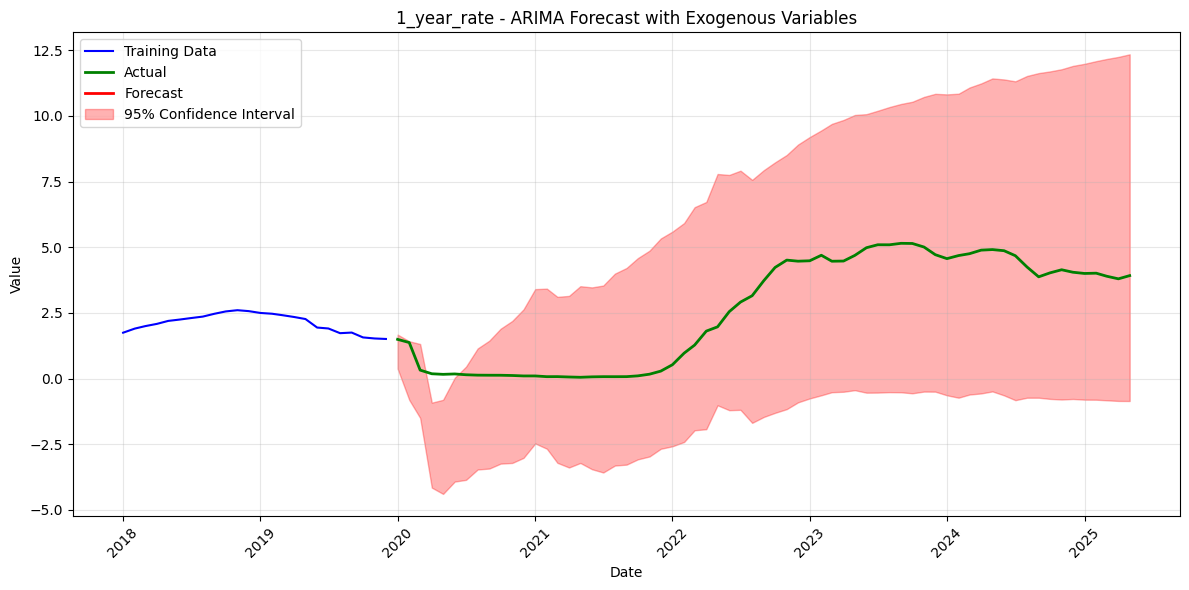


Forecasting: 3_months_rate

3_months_rate Stationarity Test:
ADF Statistic: -1.869398
p-value: 0.346591
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2943.168028044157
Trying ARIMA order: (0,0,1)
  Success: AIC = 2329.21463816685
Trying ARIMA order: (0,0,2)


In [15]:
all_results, forecasted_values, train_data, test_data = run_time_series_forecasting(dim_reduced_df, financial_indicators)


In [10]:

# Prepare summary table
metrics_list = []

for indicator, res in all_results.items():
    metrics_list.append({
        'Indicator': indicator,
        'MAE': res['mae'],
        'RMSE': res['rmse'],
        'MAPE_%': res['mape']
    })

metrics_df = pd.DataFrame(metrics_list).set_index('Indicator')

print("\nForecast Performance Metrics:")
print(metrics_df.round(4))

NameError: name 'all_results' is not defined